In [1]:
import pandas as pd
import numpy as np
import os
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

In [ ]:
# column info
# data from https://www.kaggle.com/datasets/doanquanvietnamca/liar-dataset?resource=download
'''
Column 1: the ID of the statement ([ID].json).
Column 2: the label.
Column 3: the statement.
Column 4: the subject(s).
Column 5: the speaker.
Column 6: the speaker's job title.
Column 7: the state info.
Column 8: the party affiliation.
Column 9-13: the total credit history count, including the current statement.
9: barely true counts.
10: false counts.
11: half true counts.
12: mostly true counts.
13: pants on fire counts.
Column 14: the context (venue / location of the speech or statement).
'''

In [2]:
train = pd.read_csv("train_cleaned.csv").drop("Unnamed: 0",axis=1)
test = pd.read_csv("test_cleaned.csv").drop("Unnamed: 0",axis=1)
val = pd.read_csv("val_cleaned.csv").drop("Unnamed: 0",axis=1)
all_data = pd.concat([train, test, val], ignore_index=True)

In [3]:
train = pd.read_csv("train_cleaned.csv").drop("Unnamed: 0",axis=1)
test = pd.read_csv("test_cleaned.csv").drop("Unnamed: 0",axis=1)
val = pd.read_csv("val_cleaned.csv").drop("Unnamed: 0",axis=1)

# remove rows where statement < 3 words
def remove_short_and_long_statements(df):
    df["len"] = df["statement"].str.split().str.len()
    df = df[df["len"] >= 3]
    df = df[df["len"] <= 100]
    df = df.drop("len", axis = 1)
    return df

train = remove_short_and_long_statements(train)
test = remove_short_and_long_statements(test)
val = remove_short_and_long_statements(val)

In [7]:
train.head()

,id,label,statement,subject,speaker,speaker_job,state,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,single_subject,cleaned_context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,abortion,mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,history,floor speech
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,foreign-policy,denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,unknown,unknown,none,7.0,19.0,3.0,5.0,44.0,a news release,health-care,news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,unknown,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,economy,interview cnn


In [ ]:
# logistic regression
# shap values for lightgbm
# supervised lda

# simple logistic regression

In [13]:
from sklearn.preprocessing import OneHotEncoder

In [25]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train[["single_subject"]])

OneHotEncoder(handle_unknown='ignore')

In [26]:
# train set
train_other_feats = train[["barely_true_counts", "false_counts", "half_true_counts",
                           "mostly_true_counts", "pants_on_fire_counts"]].to_numpy()
X_train = np.concatenate((train_other_feats, enc.transform(train[["single_subject"]]).toarray()), axis = 1)

# test set
test_other_feats = test[["barely_true_counts", "false_counts", "half_true_counts",
                           "mostly_true_counts", "pants_on_fire_counts"]].to_numpy()
X_test = np.concatenate((test_other_feats, enc.transform(test[["single_subject"]]).toarray()), axis = 1)

# val set
val_other_feats = val[["barely_true_counts", "false_counts", "half_true_counts",
                           "mostly_true_counts", "pants_on_fire_counts"]].to_numpy()
X_val = np.concatenate((val_other_feats, enc.transform(val[["single_subject"]]).toarray()), axis = 1)

y_train = train["label"]
y_test = test["label"]
y_val = val["label"]

In [27]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [28]:
y_pred = classifier.predict(X_test)

In [29]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.2905779889152811


In [31]:
mae(pd.Series(y_pred), y_test)

1.4204275534441806

# logistic regression

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [33]:
# combine all text features into one column
def combine_text_features(df):
    speakers = df["speaker"].str.split("-").str.join(" ")
    df["combined_text"] = df["statement"] + " " + df["context"] + " " + df["single_subject"] + " " + df["speaker"] + " " + df["speaker_job"] + " " + df["state"] + " " + df["party"]
    return df

In [34]:
train = combine_text_features(train)
test = combine_text_features(test)
val = combine_text_features(val)

In [35]:
# bag of words for text features
vec = CountVectorizer(max_features = 1000, stop_words = "english")
vec.fit(train["combined_text"])

CountVectorizer(max_features=1000, stop_words='english')

In [36]:
# train set
train_other_feats = train[["barely_true_counts", "false_counts", "half_true_counts", 
                           "mostly_true_counts", "pants_on_fire_counts"]].to_numpy()
X_train = np.concatenate((train_other_feats, vec.transform(train["combined_text"]).toarray()), axis = 1)
y_train = train["label"]

# test set
test_other_feats = test[["barely_true_counts", "false_counts", "half_true_counts", 
                           "mostly_true_counts", "pants_on_fire_counts"]].to_numpy()
X_test = np.concatenate((test_other_feats, vec.transform(test["combined_text"]).toarray()), axis = 1)
y_test = test["label"]

# val set
val_other_feats = val[["barely_true_counts", "false_counts", "half_true_counts", 
                           "mostly_true_counts", "pants_on_fire_counts"]].to_numpy()
X_val = np.concatenate((val_other_feats, vec.transform(val["combined_text"]).toarray()), axis = 1)
y_val = val["label"]

In [37]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [38]:
y_pred = classifier.predict(X_test)

In [39]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.2905779889152811


In [40]:
def mae(pred, actual):
    pred_num = pred.replace({"pants-fire": 0, "false": 1, "barely-true": 2, "half-true": 3, 
                             "mostly-true": 4, "true": 5})
    actual_num = actual.replace({"pants-fire": 0, "false": 1, "barely-true": 2, "half-true": 3, 
                                 "mostly-true": 4, "true": 5})
    return np.sum(np.abs(pred_num - actual_num)) / len(pred)

In [41]:
mae(pd.Series(y_pred), y_test)

1.4972288202692003

# LightGBM

In [71]:
import lightgbm as lgb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

In [72]:
train = pd.read_csv("train_cleaned.csv").drop("Unnamed: 0",axis=1)
test = pd.read_csv("test_cleaned.csv").drop("Unnamed: 0",axis=1)
val = pd.read_csv("val_cleaned.csv").drop("Unnamed: 0",axis=1)

# remove rows where statement < 3 words
def remove_short_and_long_statements(df):
    df["len"] = df["statement"].str.split().str.len()
    df = df[df["len"] >= 3]
    df = df[df["len"] <= 100]
    df = df.drop("len", axis = 1)
    return df

train = remove_short_and_long_statements(train)
test = remove_short_and_long_statements(test)
val = remove_short_and_long_statements(val)

In [73]:
# combine bag of words matrix with historical count features, context bag of words matrix
vec = TfidfVectorizer(max_features = 1000, stop_words = "english") # TfidfVectorizer
vec.fit(train["statement"])
vec2 = TfidfVectorizer(max_features = 500, stop_words = "english") # for context
vec2.fit(train["context"])

# convert single subject to int
train["single_subject_int"] = pd.factorize(train["single_subject"])[0]
test["single_subject_int"] = pd.factorize(test["single_subject"])[0]
val["single_subject_int"] = pd.factorize(val["single_subject"])[0]

# train set
train_other_feats = train[["barely_true_counts", "false_counts", "half_true_counts", 
                           "mostly_true_counts", "pants_on_fire_counts"]].to_numpy()
X_train = np.concatenate((train_other_feats, vec.transform(train["statement"]).toarray(), 
                               vec2.transform(train["context"]).toarray()), axis = 1)

# test set
test_other_feats = test[["barely_true_counts", "false_counts", "half_true_counts", 
                         "mostly_true_counts", "pants_on_fire_counts"]].to_numpy()
X_test = np.concatenate((test_other_feats, vec.transform(test["statement"]).toarray(), 
                               vec2.transform(test["context"]).toarray()), axis = 1)

# val set
val_other_feats = val[["barely_true_counts", "false_counts", "half_true_counts", 
                       "mostly_true_counts", "pants_on_fire_counts"]].to_numpy()
X_val = np.concatenate((val_other_feats, vec.transform(val["statement"]).toarray(), 
                               vec2.transform(val["context"]).toarray(), ), axis = 1)

y_train = train["label"].replace({"pants-fire": 0, "false": 1, "barely-true": 2, "half-true": 3, 
                             "mostly-true": 4, "true": 5})
y_test = test["label"].replace({"pants-fire": 0, "false": 1, "barely-true": 2, "half-true": 3, 
                             "mostly-true": 4, "true": 5})
y_val = val["label"].replace({"pants-fire": 0, "false": 1, "barely-true": 2, "half-true": 3, 
                             "mostly-true": 4, "true": 5})

In [75]:
params = {
    'objective': 'multiclass', "num_class": 6,
    'metric': 'multi_logloss',
    'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 15
}

# Create a LightGBM classifier object and fit it to the training data
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)

# Make predictions on the test set and evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print("mae", mae(pd.Series(y_pred), y_test))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26221
[LightGBM] [Info] Number of data points in the train set: 10227, number of used features: 1134
[LightGBM] [Info] Start training from score -2.500576
[LightGBM] [Info] Start training from score -1.638405
[LightGBM] [Info] Start training from score -1.821835
[LightGBM] [Info] Start training from score -1.577396
[LightGBM] [Info] Start training from score -1.651577
[LightGBM] [Info] Start training from score -1.809815
accuracy 0.4259699129057799
              precision    recall  f1-score   support

           0       0.60      0.52      0.56        92
           1       0.41      0.53      0.46       247
           2       0.48      0.33      0.39       212
           3       0.38      0.47      0.42       264
           4       0.

In [78]:
import shap

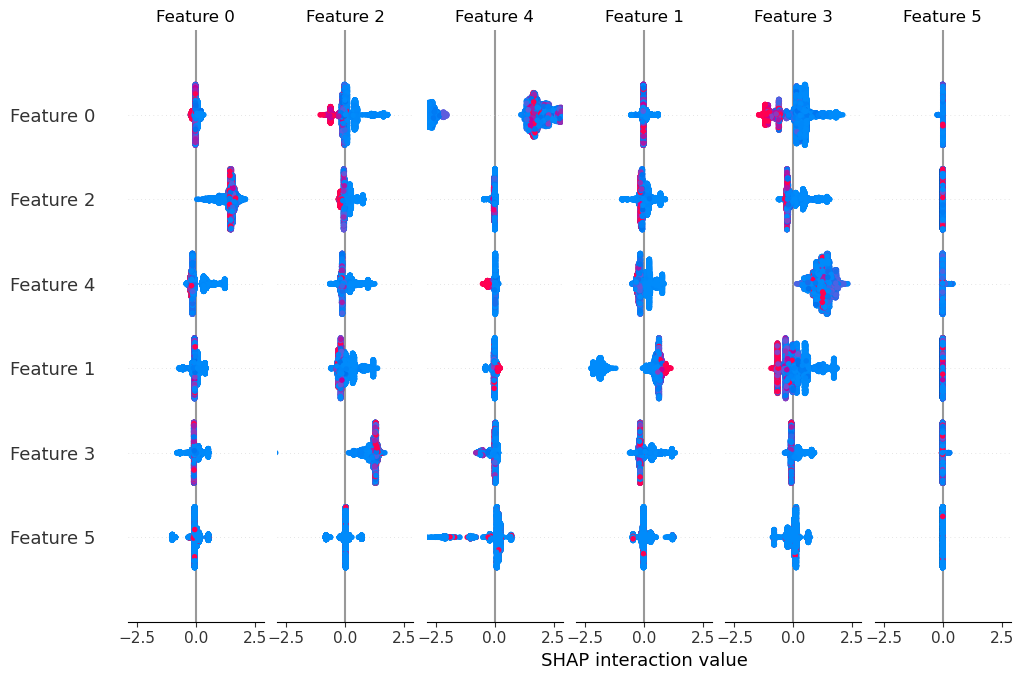

In [79]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

In [80]:
vec.get_feature_names()

/Users/emilydu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['000',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '150',
 '16',
 '17',
 '18',
 '19',
 '20',
 '200',
 '2000',
 '2001',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '21',
 '22',
 '23',
 '24',
 '25',
 '250',
 '27',
 '28',
 '29',
 '30',
 '300',
 '35',
 '36',
 '38',
 '40',
 '400',
 '42',
 '45',
 '50',
 '500',
 '60',
 '600',
 '70',
 '700',
 '75',
 '80',
 '800',
 '90',
 '95',
 '99',
 'able',
 'abortion',
 'abortions',
 'access',
 'according',
 'account',
 'act',
 'action',
 'actually',
 'add',
 'added',
 'additional',
 'administration',
 'affordable',
 'afghanistan',
 'african',
 'age',
 'agencies',
 'agency',
 'ago',
 'agreement',
 'aid',
 'air',
 'al',
 'alaska',
 'aliens',
 'allow',
 'allowed',
 'allowing',
 'amendment',
 'america',
 'american',
 'americans',
 'americas',
 'amnesty',
 'annual',
 'anti',
 'anybody',
 'approved',
 'approximately',
 'arabia',
 'area',
 'arizona',
 'asked',
 'assault',
 'atlanta',
 'attack',
 'attacks',
 '